This notebook provides some additional information to help us decide how to approach addressing the reviewer's comments

In [15]:
import os
import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from IPython.display import display

# Add this repo to the path
src_dir = os.path.normpath(os.path.join(os.getcwd(), '../util'))
sys.path.insert(0, src_dir)
import FileIO as fio
import Formatting as fmt


## Comment: the definition of ‘cases’ may need reconsidering for some diseases

> Similar to the concern over the data used for the Schubert CDI data, the definition of ‘cases’ may need reconsidering for some diseases - what is a case for an HIV patient, for instance? Actively replicating virus? Reduced CD4 count? People that are HIV positive are often quite healthy with no detectable viral load. Similarly, IBD encompasses a range of bowel diseases and a ‘case’ of UC is different from a ‘case’ of Crohn’s. Further, a note or clarification of whether any of these patients were on antibiotics (and if this could be a confounding factor) is necessary.

It's true, I combined UC and CD patients in 3 out of 4 IBD studies (one study only had CD). Mentioning confounding factors can be addressed more clearly in the paper, as well as in the reviewer response (we honestly don't have that kind of metadata for the majority of these studies...).

But what should we do about these IBD studies? And others which have multiple types of cases?

In [10]:
yaml_file = '../../data/user_input/results_folders.yaml'
raw_data_dir = '../../data/raw_otu_tables'
clean_data_dir = '../../data/clean_tables'

In [15]:
yamlinfo = fio.read_yaml(yaml_file, raw_data_dir)

# Read the datasets

dfs = dict.fromkeys(yamlinfo.keys())
for dataset in yamlinfo:
    df, meta = fio.read_dataset_files(dataset, clean_data_dir)
    
    # Store dataframes so I only have to read them once
    dfs[dataset] = {'df': df, 'meta': meta}    

In [16]:
# Get case/control numbers
statslst = {}

for dataset in dfs:
    meta = dfs[dataset]['meta']
    
    classes_list = fio.get_classes(meta)
    [h_smpls, dis_smpls] = fio.get_samples(meta, classes_list)
    
    statslst[dataset] = dict.fromkeys(['cases', 'controls'])
    statslst[dataset]['controls'] = {i: len(meta.query('DiseaseState == @i')) for i in classes_list[0]}
    statslst[dataset]['cases'] = {i: len(meta.query('DiseaseState == @i')) for i in classes_list[1]}

In [19]:
for dataset in statslst:
    if len(statslst[dataset]['cases']) > 1:
        print(dataset, statslst[dataset]['cases'])


('ra_scher', {'PSA': 16, 'RA': 70})
('ibd_papa', {'UC': 43, 'CD': 23})
('mhe_zhang', {'CIRR': 25, 'MHE': 21})
('ibd_morgan', {'UC': 47, 'CD': 61})
('ibd_willing', {'UC': 16, 'CD': 29})


** I think we can just do these split analyses! **

I was planning on separating the Liver cirrhosis (CIRR) and Minimal hepatic encelopathy (MHE) analyses and the Psoriatic arthritis (PSA) and rheumatoid arthritis (RA) anyway. Might as well also split up the UC/CD comparisons... I think this will significantly lower our power to detect anything but hopefully still a few things come up.

#### Note: I already re-did the IBD and CDI analyses

The disease-specific heatmaps are in microbiomeHD repo, branch split_cases. In folder split_results.

## Comment: CDI bugs are over-represented in 'core' microbes?

> When testing and generating the ‘core’ microbiome across all diseases, we wonder whether testing for the core falsely amplified the CDI-related microbes in the pan-disease core because there were so many that were altered in cases?

In [67]:
fn_core = '../../data/analysis_results/meta.counting.q-0.05.2_diseases.across_all_diseases.sig_ordered.txt'
fn_disease = '../../data/analysis_results/meta.counting.q-0.05.disease_wise.sig_ordered.txt'
fn_allpvals = '../../data/analysis_results/q-val_all_results.mean.kruskal-wallis.case-control.sig_ordered.txt'

overall_meta = pd.read_csv(fn_core, sep='\t', index_col=0)
disease_meta = pd.read_csv(fn_disease, sep='\t', index_col=0)
pvals = pd.read_csv(fn_allpvals, sep='\t', index_col=0)

In [25]:
#overall_meta.dropna(how='all').head()

,overall
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium,1.0
k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia,-1.0
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiales_Incertae_Sedis_XI;g__Parvimonas,1.0
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiales_Incertae_Sedis_XI;g__Peptoniphilus,1.0
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Incertae_Sedis_XI;g__Murdochiella,-1.0


In [26]:
#disease_meta.dropna(how='all').head()

,crc,ob,ibd,cdi,hiv
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium,1.0,NaN,NaN,1.0,NaN
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiales_Incertae_Sedis_XI;g__Parvimonas,1.0,NaN,NaN,1.0,NaN
k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Veillonellaceae;g__Dialister,NaN,NaN,NaN,-1.0,NaN
k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Veillonellaceae;g__Veillonella,NaN,NaN,NaN,1.0,NaN
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus,NaN,NaN,NaN,1.0,NaN


In [49]:
allmeta = pd.merge(overall_meta, disease_meta, how='outer', left_index=True, right_index=True)
#allmeta.dropna(how='all').head()

,overall,crc,ob,ibd,cdi,hiv
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium,1.0,1.0,NaN,NaN,1.0,NaN
k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia,-1.0,NaN,NaN,NaN,NaN,NaN
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiales_Incertae_Sedis_XI;g__Parvimonas,1.0,1.0,NaN,NaN,1.0,NaN
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiales_Incertae_Sedis_XI;g__Peptoniphilus,1.0,NaN,NaN,NaN,NaN,NaN
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Incertae_Sedis_XI;g__Murdochiella,-1.0,NaN,NaN,NaN,NaN,NaN


In [80]:
dis = ['crc', 'ob', 'ibd', 'cdi', 'hiv']
for d in dis:
    n = sum(allmeta[d] == allmeta['overall'])
    print('{} bugs are both {}-associated and core'.format(n, d))


4 bugs are both crc-associated and core
5 bugs are both ob-associated and core
5 bugs are both ibd-associated and core
23 bugs are both cdi-associated and core
0 bugs are both hiv-associated and core


In [81]:
# This shows the number of genera which are both disease-associated and overall-associated for each of the diseases
for d in dis:
    tmp = allmeta[d].dropna()
    n = sum(tmp != allmeta.loc[tmp.index, 'overall'])    
    print('{} bugs are {}-associated but *not* core'.format(n, d))

1 bugs are crc-associated but *not* core
1 bugs are ob-associated but *not* core
0 bugs are ibd-associated but *not* core
12 bugs are cdi-associated but *not* core
0 bugs are hiv-associated but *not* core


In [86]:
# How about... how many bugs are overall-associated and *not* in any of these diseases?
overall_bugs = allmeta.dropna(subset=['overall']).index
disease_bugs = allmeta.dropna(subset=dis, how='all').index
overall_not_disease = [i for i in n1 if i not in n2]
print('{} core bugs are not consistently associated with any one disease'.format(len(overall_not_disease)))

33 core bugs are not consistently associated with any one disease


In [89]:
# Now, of those 33 bugs... how many are significant in at least one diarrhea dataset?
diar = pvals[[i for i in pvals if i.startswith('cdi') or i == 'edd_singh']]
pthresh = 0.05
sigmap = lambda x: np.sign(x) if abs(x) < pthresh else np.nan
diar = diar.applymap(sigmap).dropna(how='all')
#diar.head()

In [98]:
overall_not_diar = [i for i in overall_bugs if i in diar.index]
print('{} core bugs are significant in at least one diarrhea dataset'.format(len(overall_not_diar)))

54 core bugs are significant in at least one diarrhea dataset


Summary:

* there are 64 total "core" genera
* 23 genera are both cdi-associated and core (i.e. sig in >= diarrhea datasets *and* in >= 2 diseases)
* 12 genera are cdi-associated but **not** core (i.e. sig in >= 2 diarrhea datasets but not in >= 2 diseases)
* 54/64 core genera are significant in at least one diarrhea dataset

#### Take-away: yes, diarrhea bacteria are over-represented in the "core" response, but I think it's fine.

You would expect that the bugs involved a total restructuring of the microbiome would be part of a "core" response to health and disease. Besides, it looks like there are still definitely core bacteria which are not associated in more than 2 diarrhea datasets. Furthermore, the "percent overlap" figure in the paper shows that our "core" bacteria do generalize across diseases...

## Comment: more datasets?

In terms of analysis, not that hard to include more datasets. Might be annoying to work into the paper...

Here are the datasets I could possibly include (and why I haven't included them yet)

* IBS, Saulnier - 22 IBS, 22 healthy (children, > 5 years old)
    * http://www.sciencedirect.com/science/article/pii/S001650851100922X
    * SRA data has disease metadata and raw data
    * but there are multiple time points per patient, which aren't labeled (so I'd have to guess which is the first time point or randomly pick one sample per patient)
    * **I should probably process this one...**
* IBS, Jeffery - 37 IBS, 20 healthy
    * I have the metadata and data from the author
    * But the data is poorly organized and hard to figure out what's what (it's in S3)
    * **I could definitely do this one, but it would take me half a day at least...**
* IBS, Pozuelo - 113 IBS, 66 healthy
    * Don't remember why I didn't process this one, looks like I have all the data...
    * I think the disease metadata is a in pdf supplement or something.
    * **I should probably process this one...**
* IBS, Parthasarathy - 25 IBS-C, 25 controls (all women)
    * also has BMI data
    * data is in SRA, **could process**
* OB, Murugesan - 81 normal, 29 overweight, and 80 obese children
    * data is in SRA now, **could process**
* OB, Yatsunenko - 531 people with BMI data, not sure breakdown by case/control
    * Broke usearch so I hadn't processed it,
    * I could process again with MIN_COUNT = 10 (I did this for ob_goodrich, actually)
    * **I should probably process this one...**
* T1D, Davis-Richardson - 29 T1D, 47 healthy
    * This data was really bad, if we include it I think it will be with trim length = 101 bp, and losing lots of samples I think
    * **I could probably process this, but not sure if it's worth it or if we trust the data...**
* Metabolic syndrome, Stadlbauer - 15 MetS, 16 healthy
    * Not sure if I have metadata
    * Probably not worth it
* Spinal cord injury - 30 SCI, 10 controls
    * Have all the data, **could process**
* breast cancer - 48 cancer, 48 controls
    * Data is now in SRA, **could process**
* and quite a few others which are probably on SRA now...

## Comment: make a classifier based on core bugs

Okay, I did this. Note that not every dataset has all of the core bugs present.

In [65]:
fn_rf_core = '../../data/analysis_results/rf_results.core_only.txt'
fn_rf_all = '../../data/analysis_results/rf_results.txt'
fn_rf_random = '../../data/analysis_results/rf_results.random_genera.txt'
rf_all = pd.read_csv(fn_rf_all, sep='\t')
rf_core = pd.read_csv(fn_rf_core, sep='\t')
rf_random = pd.read_csv(fn_rf_random, sep='\t')
#rf_core.head()

rf_core = rf_core[['dataset', 'roc_auc']].drop_duplicates()
rf_core.columns = ['dataset', 'auc_core']
rf_all = rf_all[['dataset', 'roc_auc']].drop_duplicates()
rf_all.columns = ['dataset', 'auc_all']
rf_random = rf_random[['dataset', 'roc_auc']].drop_duplicates()
rf_random.columns = ['dataset', 'auc_random']
rf_both = pd.merge(rf_all, rf_core)
rf_both = pd.merge(rf_both, rf_random)
rf_both.head()

,dataset,auc_all,auc_core,auc_random
0,mhe_zhang,0.80119,0.804792,0.777722
1,mhe_zhang,0.80119,0.804792,0.757935
2,mhe_zhang,0.80119,0.804792,0.801279
3,mhe_zhang,0.80119,0.804792,0.657138
4,mhe_zhang,0.80119,0.804792,0.747183


In [66]:
rf_both = pd.melt(rf_both, id_vars='dataset')
#rf_both.head()

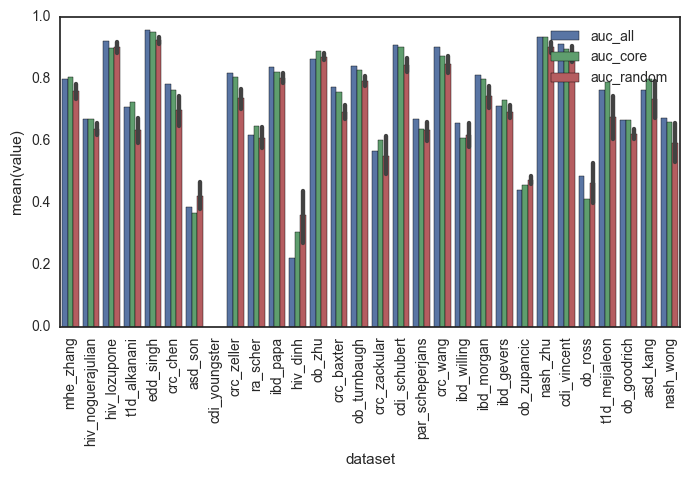

In [69]:
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x='dataset', y='value', hue='variable', data=rf_both, ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(loc='upper right')

It works! Dubiously well... another thing I could try is to look at what percent of each original classifier's top features are core bugs.

In fact, if I build classifiers based on the same number of genera, but randomly chosen (as opposed to just the "core"), then I get the same results. Perhaps I need to exclude the core genera from these "random" classifiers? Or pick a different classifier type that's less good at finding subtle signals?

## Comment: 'core'-definining heuristic is not complicated enough

Reviewer #1:

> Similarly, we wondered how the authors could control for the variation in effect sizes when generating the list of core microbes? We would encourage something like a Z-transform like was used in the Sze and Schloss obesity meta-analysis

Reviewer #2:

> I did not think that the definition was rigorous enough. Can a genus that “is significantly enriched or depleted in at last one dataset from at least 2 different diseases)” really be considered a “core”?

> Lines 325-327: the point is made that “Individual studies are plagued by low statistical power, confounding variables etc.” Isn’t that also a weakness of the analysis conducting here since you are just re-analyzing all of the original studies and seeing where they agree? One way to actually increase power would be to apply Fisher’s method

In [26]:
fn_core = '../../data/analysis_results/meta.counting.q-0.05.2_diseases.across_all_diseases.sig_ordered.txt'
fn_stouffer = '../../data/analysis_results/meta.stouffer.q-0.05.across_all_diseases.txt'
stouffer = pd.read_csv(fn_stouffer, sep='\t')
stouffer.columns = ['otu', 'stouffer_overall']
core = pd.read_csv(fn_core, sep='\t')
core.columns = ['otu', 'core_overall']

both = pd.merge(stouffer, core)
both.index = both['otu']
both = both[['stouffer_overall', 'core_overall']]
# Re-order rows
both = both.loc[both.sum(axis=1).sort_values(ascending=False).index]

In [27]:
both.dropna(how='all').head()

,stouffer_overall,core_overall
otu,,
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiales_Incertae_Sedis_XIII;g__Mogibacterium,1.0,1.0
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;g__Cronobacter,1.0,1.0
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus,1.0,1.0
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus,1.0,1.0
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__Peptostreptococcus,1.0,1.0


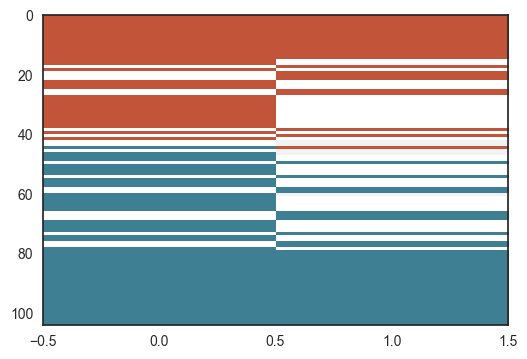

In [28]:
sns.set_style('white')
fig, ax = plt.subplots()

# Left column is Stouffer results, right column is heuristic
cax = ax.imshow(both.dropna(how='all').values, interpolation='nearest',
                        aspect='auto',
                        cmap=sns.diverging_palette(220,20,as_cmap=True))

Left column is the Stouffer results, right column is the heuristic results.

Looks like they don't disagree: only one bug is conflicting. Other disagreements are just bugs that one method doesn't consider core but the other one does.

In [34]:
both[both.sum(axis=1) == 0].dropna()

,stouffer_overall,core_overall
otu,,
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas,-1.0,1.0


In [35]:
both.query('core_overall == 0')

,stouffer_overall,core_overall
otu,,
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium_XlVb,NaN,0.0
k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Catenibacterium,NaN,0.0
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella,NaN,0.0
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes,-1.0,0.0
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Flavonifractor,-1.0,0.0


I think we can make a good argument that we *could* have used something more statistically complicated, but it doesn't get at what we really want. We want to find bacteria that respond to multiple *diseases* - so using Stouffer would only make sense if we first had a summary p-value for each of the diseases.

Ironically, using Stouffer is more likely to predispose use to having CDI bugs overrepresented in the core bugs (I think - I could check I guess) because three small p-values in three diarrhea studies is probably enough to count as significant.

In [71]:
np.random?